In [2]:
from matplotlib import pyplot as plt
import json
import numpy as np
import pandas as pd
from collections import OrderedDict

pcolors = OrderedDict([('blue', [0.00, 0.33, 0.66]),
                       ('green', [0.33, 0.66, 0.00]),
                       ('red', [0.66, 0.00, 0.00]),
                       ('cyan', [0.00, 0.66, 0.66]),
                       ('purple', [0.33, 0.00, 0.66]),
                       ('orange', [0.75, 0.50, 0.00])])

plt.rcParams['figure.figsize'] = (3.3, 2)
plt.rcParams['figure.dpi'] = 240
plt.rcParams['font.family'] = 'Open Sans'
plt.rcParams['font.size'] = 8
plt.rcParams['axes.titlesize'] = 'medium'
plt.rcParams['axes.labelsize'] = 'medium'
plt.rcParams['axes.linewidth'] = 0.5
plt.rcParams['xtick.labelsize'] = 'small'
plt.rcParams['ytick.labelsize'] = 'small'
plt.rcParams['legend.fontsize'] = 'small'
plt.rcParams['lines.linewidth'] = 0.75
plt.rcParams['lines.markersize'] = 4
plt.rcParams['lines.markeredgewidth'] = 0.5
plt.rcParams['legend.fontsize'] = 'small'
plt.rcParams['legend.frameon'] = False
plt.rcParams['patch.linewidth'] = 0.5
plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams['savefig.edgecolor'] = 'w'
plt.rcParams['savefig.facecolor'] = 'w'
plt.rcParams['savefig.dpi'] = 600

%matplotlib inline

rc = %config InlineBackend.rc
rc['savefig.dpi'] = 150

In [3]:
# setup 
instance_ids = ['4x4', '5x5', '7x8', '10x10']
train_range = [1, 2, 5, 10, 20, 50, 100, 200, 500, 1000]
particles = 1000
hed = 10.
rho = 1.0
gamma = 0.9
kappa = 0.5

results_dir = '../results/rockwalk/'

In [4]:
# load instance info
instances = json.load(open('../resources/rockwalk/instances.json', 'r'))

In [5]:
# load trials
trial_path = '%s/rockwalk-%s-d%.1f-rho%.1f-gamma%.1f-kappa%.1f-steps%05d-test%d.json' 
trials = {}
for i in instance_ids:
    trials[i] = {}
    for n in train_range:
        try:
            trials[i][n] = json.load(open(trial_path % (results_dir,i,hed,rho,gamma,kappa,n,particles), 'r'))
            print '.',
        except:
            pass        

. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


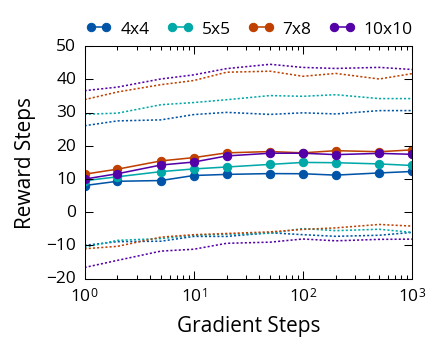

In [12]:
# plot quantiles for rewards as a function of number of iterations
quantiles = [0.25,0.5,0.75]
rewards = pd.DataFrame(dict(((i,n), trials[i][n]['rewards']) 
                            for i in trials for n in trials[i]))
rquantiles = pd.concat([rewards.quantile(q) 
                        for q in quantiles], 
                       keys=quantiles, axis=1)\
               .unstack(level=0)\
               .swaplevel(0,1,1)

colors = {'4x4': [0.00, 0.33, 0.66],
          '5x5': [0.00, 0.66, 0.66],
          '7x8': [0.75, 0.25, 0.00],
          '10x10': [0.33, 0.00, 0.66]}

fig = plt.figure(figsize=(2.75,2.0))
ax = fig.gca()
for i in instance_ids:
    mean_reward = rewards[i].mean()
    std_reward = rewards[i].std()
    min_reward = mean_reward - 2 * std_reward
    max_reward = mean_reward + 2 * std_reward
    ax.semilogx(mean_reward.index,
            mean_reward.values,
            '-o', mec=colors[i],
            color = colors[i],
            label = i)
    ax.semilogx(min_reward.index,
            min_reward.values,
            color = colors[i],
            linestyle = '--',
            dashes=(1,1))
    ax.semilogx(max_reward.index,
            max_reward.values,
            color = colors[i],
            linestyle = '--',
            dashes=(1,1))

lgd = ax.legend(bbox_to_anchor=(0.15, 1.075, 0.9, .10), ncol=5, 
               handlelength=1.5, handletextpad=0.5, columnspacing=1.0)
ax.set_ylabel('Reward Steps')
ax.set_xlabel('Gradient Steps')

ax.set_ylim([-20,50])

fig.tight_layout(pad=0.05)
for ext in ['png','pdf','svg']:
    fig.savefig('../plots/rockwalk/rockwalk_reward_vs_steps.%s' % ext,
                bbox_extra_artists=(lgd,), bbox_inches='tight')

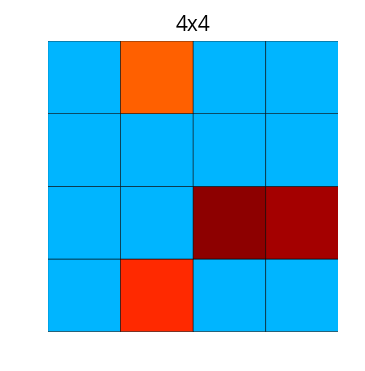

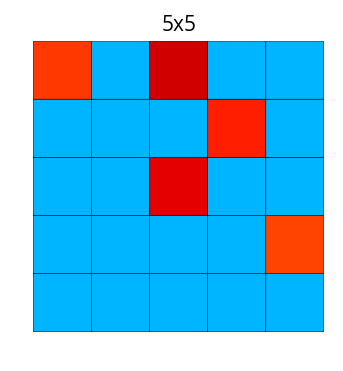

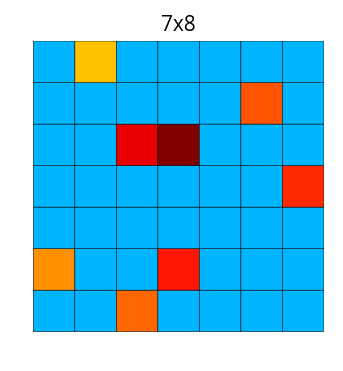

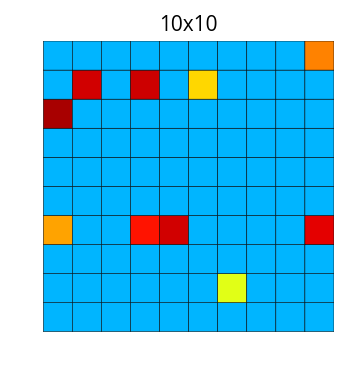

In [7]:
def plot_rock_counts(trial, instance, axis=None, **kwargs):
    if axis is None:
        axis = plt.gca()
    grid = np.zeros((instance['n'],instance['n'])) 
    for ((x,y),count) in trials[i][n]['rock-counts']:
        grid[x,y] = 1.0 * count / len(trials[i][n]['rewards']) 
    axis.pcolor(grid.T,
                **kwargs)
    axis.set_title(i)
    plt.axis('off')

for i in instance_ids:
    if len(trials[i].keys()):
        n = np.max(trials[i].keys())
        fig = plt.figure(figsize=(2.5,2.5))
        axis = fig.gca()
        plot_rock_counts(trials[i][n],
                         instances[i],
                         axis=axis,
                         cmap=plt.cm.jet,
                         vmin=-0.35,
                         vmax=0.8,
                         edgecolors='k')
    


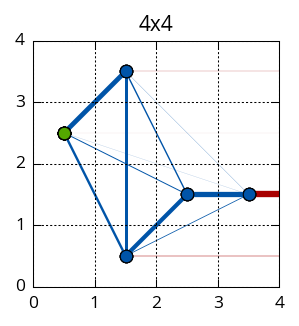

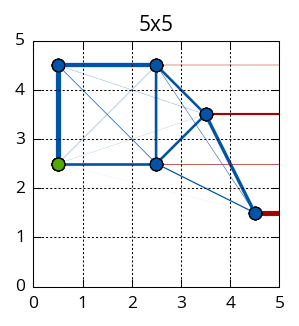

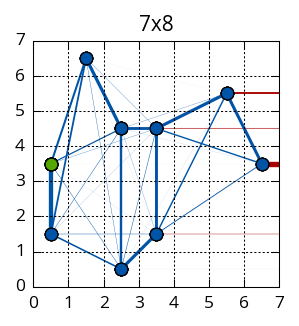

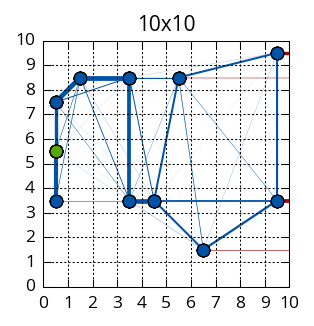

In [10]:
def plot_travel_counts(trial, instance, axis=None, **kwargs):
    if axis is None:
        axis = plt.gca()
    linewidth = kwargs.get('linewidth', 4.0)
    for (((xa,ya), (xb,yb)), count) in trial['travel-counts']:
        kwargs['linewidth'] = linewidth * count / len(trial['rewards']) 
        try:
            kw = dict(kwargs)
            if xb == instance['n']:
                kw['color'] = pcolors['red']
                kw['zorder'] = -np.inf
            axis.plot([xa+0.5,xb+0.5], [ya+0.5,yb+0.5], 'o-', **kw)
            if (xa,ya) == (instance['x'],instance['y']):
                kw['color'] = pcolors['green']
                kw['zorder'] = np.inf
                axis.plot([xa+0.5,xa+0.5], [ya+0.5,ya+0.5], 'o-', **kw)
        except:
            print (xa,ya),(xb,yb)

for i in instance_ids:
    fig = plt.figure(figsize=(2,2))
    axis = fig.gca()
    if len(trials[i].keys()):
        n = np.max(trials[i].keys())
        plot_travel_counts(trials[i][n], 
                           instances[i],
                           axis=axis, 
                           color=pcolors['blue'], 
                           ms=6)
    axis.set_title(i)
    ticks = range(0,instances[i]['n']+1)
    axis.set_xticks(ticks)
    axis.set_yticks(ticks)
    axis.set_xlim([0,instances[i]['n']])
    axis.set_ylim([0,instances[i]['n']])
    axis.set_aspect('equal')
    axis.grid(True, linestyle='--', dashes=(1,1))

    fig.tight_layout(pad=0.05)
    for ext in ['png','pdf','svg']:
        fig.savefig('../plots/rockwalk/rockwalk_flow_%s.%s' % (i,ext),dpi=600)        

        

In [ ]:
ls